In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import time

In [2]:
%pylab inline
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

center_ra = 19.3*galsim.hours     # The RA, Dec of the center of the image on the sky
center_dec = -33.1*galsim.degrees

pix_wfirst = 0.11
pix_LSST = 0.2
pix_HST = 0.06
pix_Euclid = 0.1
pix_HSC = 0.17

#Sigma of the psf profile in arcseconds.
sigma_wfirst = 1.69*0.11 #0.185 https://arxiv.org/pdf/1702.01747.pdf Z-band
sigma_LSST = 0.7 #https://www.lsst.org/about/camera/features
sigma_Euclid = 0.16 #https://sci.esa.int/documents/33859/36320/1567253682555-Euclid_presentation_Paris_1Dec2009.pdf
sigma_HST = 0.074 #Source https://hst-docs.stsci.edu/display/WFC3IHB/6.6+UVIS+Optical+Performance#id-6.6UVISOpticalPerformance-6.6.1 800nm
sigma_HSC = 0.62 #https://hsc-release.mtk.nao.ac.jp/doc/ deep+udeep

EUCLID = {'pixel': pix_Euclid ,'psf': sigma_Euclid}
HST = {'pixel': pix_HST,'psf': sigma_HST}
HSC = {'pixel': pix_HSC,'psf': sigma_HSC}
WFIRST = {'pixel': pix_wfirst,'psf': sigma_wfirst}
LSST = {'pixel': pix_LSST,'psf': sigma_LSST}

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
import matplotlib.colors as mcolors
colors1 = plt.cm.nipy_spectral(np.linspace(0, 1, 128))
colors2 = plt.cm.nipy_spectral(np.linspace(1, 0, 128))
colors3 = plt.cm.nipy_spectral(np.linspace(1, 0, 128))
colors4 = plt.cm.nipy_spectral(np.linspace(0,1, 128))
colors4[:,0] = colors1[:,0]
colors4[:,1] = colors1[:,2]
colors4[:,2] = colors1[:,1]

colors3[:,0] = colors2[:,2]
colors3[:,1] = colors2[:,0]
colors3[:,2] = colors2[:,1]
# combine them and build a new colormap
colors = np.vstack((colors4, colors3))

mymap = 'gnuplot2'#mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

Populating the interactive namespace from numpy and matplotlib


In [3]:
import galsim
# First step is to find an HST PSF that will work for all images,
# we are taking a random sample of 1000 psfs, take the largest one,
# and dilate it a little bit with GalSim

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')
psfs = []
psfs_fwhm = []
npsf = 51

ims_r = [ ]

def mk_wcs(theta, pix, center, shape):
    '''Creates wcs for an image'''
    #Affine transformation
    dudx = numpy.cos(theta) * pix
    if theta == 0:
        dudy = 0
        dvdx = 0
    else:
        dudy = -numpy.sin(theta) * pix
        dvdx = numpy.sin(theta) * pix
    dvdy = numpy.cos(theta) * pix
    
    affine = galsim.AffineTransform(dudx, dudy, dvdx, dvdy, origin=center)
    #Image center
    sky_center = galsim.CelestialCoord(ra=center_ra, dec=center_dec)
    #Creating WCS
    w = WCS.WCS(naxis=2)
    galfit_wcs = galsim.TanWCS(affine, sky_center, units=galsim.arcsec)

    w.wcs.ctype = ["RA---AIR", "DEC--AIR"]
    w.wcs.crpix = galfit_wcs.crpix

    w.wcs.pc = galfit_wcs.cd
    w.wcs.crval = [galfit_wcs.center._ra._rad, galfit_wcs.center._dec._rad]
    w.array_shape = shape
    return w
    

def mk_sim(k, hr_dir, lr_dir, shape_hr, shape_lr):
    '''creates low and high resolution images of a galaxy profile with different psfs
    '''
    pix_hr = hr_dir['pixel']
    pix_lr = lr_dir['pixel']
    sigma_hr = hr_dir['psf']
    sigma_lr = lr_dir['psf']
    #Rotation angle
    theta = random.randn(1)*np.pi*0
    angle = galsim.Angle(theta,galsim.radians)
    
    #Image frames
    im_hr = galsim.Image(shape_hr[0], shape_hr[1], scale=pix_hr)
    im_lr = galsim.Image(shape_lr[0], shape_lr[1], scale=pix_lr)
    
    #Galaxy profile
    gal = cat.makeGalaxy(k, gal_type = 'real', noise_pad_size=shape_lr[0] * pix_lr*0)#cat.makeGalaxy(gal_type='real',noise_pad_size=0*shape_hr[0] * pix_lr)
    #psf hr
    psf = gal.original_psf
    #Set PSFs
    x,y, = np.arange(npsf), np.arange(npsf)
    
    psf_hr_int = galsim.Moffat(2, 0.06).dilate(sigma_hr/sigma_HST).withFlux(1.)
    psf_lr_int = galsim.Moffat(2, 0.06).dilate(sigma_lr/sigma_HST).withFlux(1.)
    
    
    #psf_hr_fft = np.fft.fft2(np.pad(psf_hr, 10))
    #psf_hr = np.fft.ifft2(psf_hr_fft.real).real[10:-10, 10:-10]
    #psf_hr_int = galsim.InterpolatedImage(galsim.Image(psf_hr), scale = pix_hr)
    psf_hr = psf_hr_int.drawImage(nx=npsf,ny=npsf, method = 'real_space',
                                  use_true_center = True, scale = pix_hr).array
    psf_lr = psf_lr_int.drawImage(nx=npsf,ny=npsf, method = 'real_space',
                                  use_true_center = True, scale = pix_lr).array
    
    #psf_lr_fft = np.fft.fft2(np.pad(psf_lr, 10))
    #psf_lr = np.fft.ifft2(psf_lr_fft.real).real[10:-10, 10:-10]
    #psf_lr_int = galsim.InterpolatedImage(galsim.Image(psf_lr), scale = pix_lr)

    #We would normally rotate the low resolution psf, but I'm a cheap bastard
    #psf_hr = galsim.InterpolatedImage(galsim.Image(psf_hr0), scale = pix_hr)
    #psf_lr = galsim.InterpolatedImage(galsim.Image(psf_lr0), scale = pix_lr)
    #Convolve by PSF, rotate and resample
    im_hr = galsim.Convolve(gal, psf_hr_int).drawImage(nx=shape_hr[0],ny=shape_hr[1], 
                                                       use_true_center = True, method = 'no_pixel',
                                                   scale = pix_hr, dtype = float64)
    im_lr = galsim.Convolve(gal.rotate(angle), psf_lr_int).drawImage(nx=shape_lr[0],ny=shape_lr[1], 
                                                                     use_true_center = True, method = 'no_pixel',
                                                                 scale = pix_lr, dtype = float64)
    
    #Make WCSs
    im_hr.wcs = mk_wcs(0, pix_hr, galsim.PositionD(im_hr.true_center), shape_hr)
    im_lr.wcs = mk_wcs(0, pix_lr, galsim.PositionD(im_lr.true_center), shape_lr)
   
    return im_hr, im_lr, psf_hr[None,:,:], psf_lr[None, :,:], theta

In [4]:
channel_hr = ['hr']
channel_lr = ['lr']

channels = channel_lr+channel_hr

def interp_scarlet(data_hr, data_lr, psf_hr, psf_lr):
    '''apply resampling from scarlet
    '''
    #Extract data
    im_hr = data_hr.array[None, :, :]
    im_lr = data_lr.array[None, :, :]

    _,n1,n2 = im_hr.shape
    shape = (len(channels), n1,n2)
    # Initialize the frame using the PSFs and WCSs
    frame = scarlet.Frame(shape, wcs=data_hr.wcs, psfs=psf_hr, channels=channels)
    
    # define two observation objects and match to frame  
    obs_hr = scarlet.Observation(im_hr, wcs=data_hr.wcs, psfs=psf_hr, channels=channel_hr)
    obs_lr = scarlet.Observation(im_lr, wcs=data_lr.wcs, psfs=psf_lr, channels=channel_lr)

    # Keep the order of the observations consistent with the `channels` parameter
    # This implementation is a bit of a hack and will be refined in the future
    obs = [obs_lr, obs_hr]
    
    frame = scarlet.Frame.from_observations(obs, obs_id = 1, coverage = 'union')
    return obs
    
def interp_galsim(data_hr, data_lr, diff_psf, angle, h_hr, h_lr):
    '''Apply resampling from galsim
    '''
    #Extract data
    im_hr = data_hr.array[None, :, :]
    im_lr = data_lr.array[None, :, :]
    _,n_hr,n_hr = im_hr.shape
    _,n_lr,n_lr = im_lr.shape
    #hr image
    gal_hr = galsim.InterpolatedImage(galsim.Image(im_hr[0]), scale = h_hr)
    
    #Rotate hr galaxy to lr frame
    rot_gal = gal_hr.rotate(galsim.Angle(angle, galsim.radians))
    #Convolve hr galaxy by diff kernel at hr
    conv_gal = galsim.Convolve(rot_gal, diff_psf)
    #Downsamples
    interp_gal = conv_gal.drawImage(nx=n_lr,ny=n_lr, scale=h_lr, method = 'no_pixel',)
    
    return interp_gal

Scarlet timing
CPU times: user 2.76 s, sys: 1.22 s, total: 3.99 s
Wall time: 2.79 s
Galsim timing
CPU times: user 305 ms, sys: 243 ms, total: 548 ms
Wall time: 251 ms
scarlet SDR:  20.035639280389965
galsim SDR:  20.615900412539023


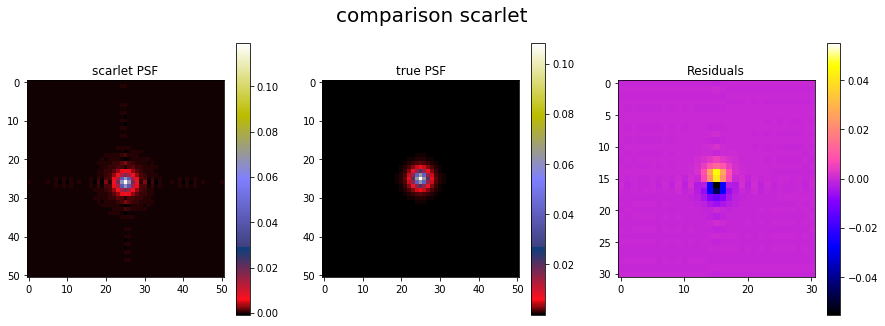

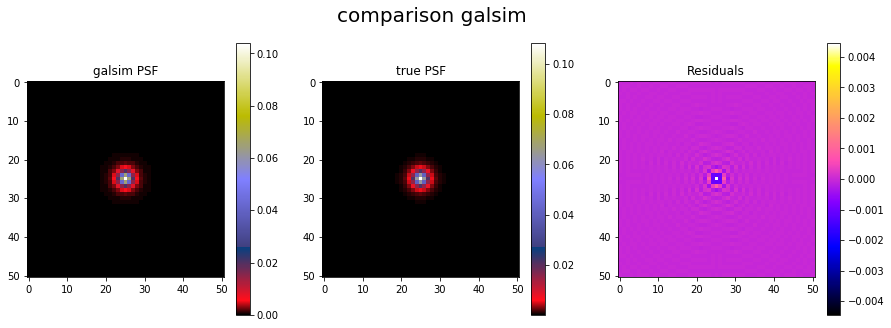

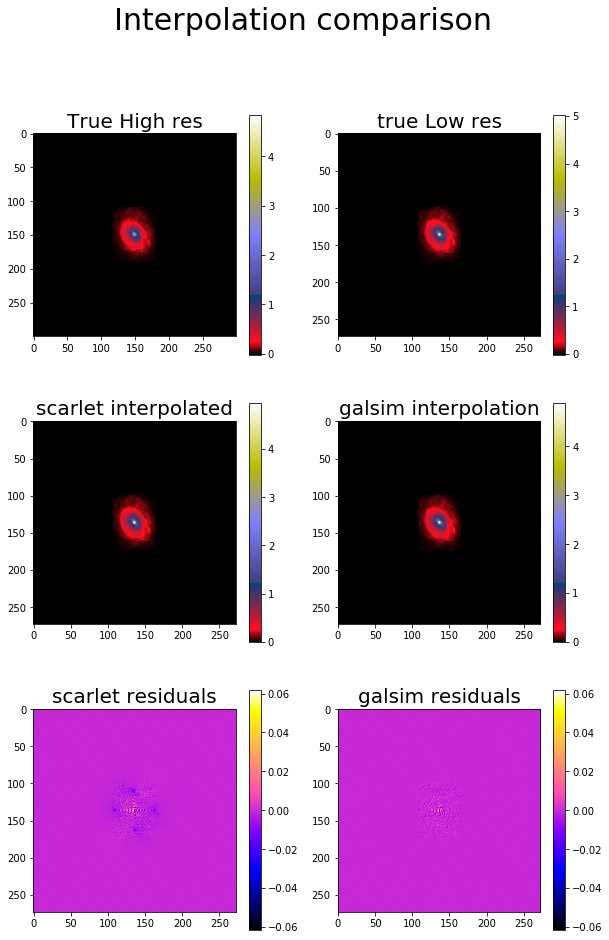

difference with scarlet fit -0.007586442372902846
difference with galsim fit -0.0001385855822417792
difference in psf 0.0009766237120527599
difference in data -0.00010620699892993635
Scarlet timing
CPU times: user 3.06 s, sys: 1.26 s, total: 4.32 s
Wall time: 2.94 s
Galsim timing
CPU times: user 392 ms, sys: 239 ms, total: 631 ms
Wall time: 307 ms
scarlet SDR:  16.51636266562807
galsim SDR:  16.80793548840985


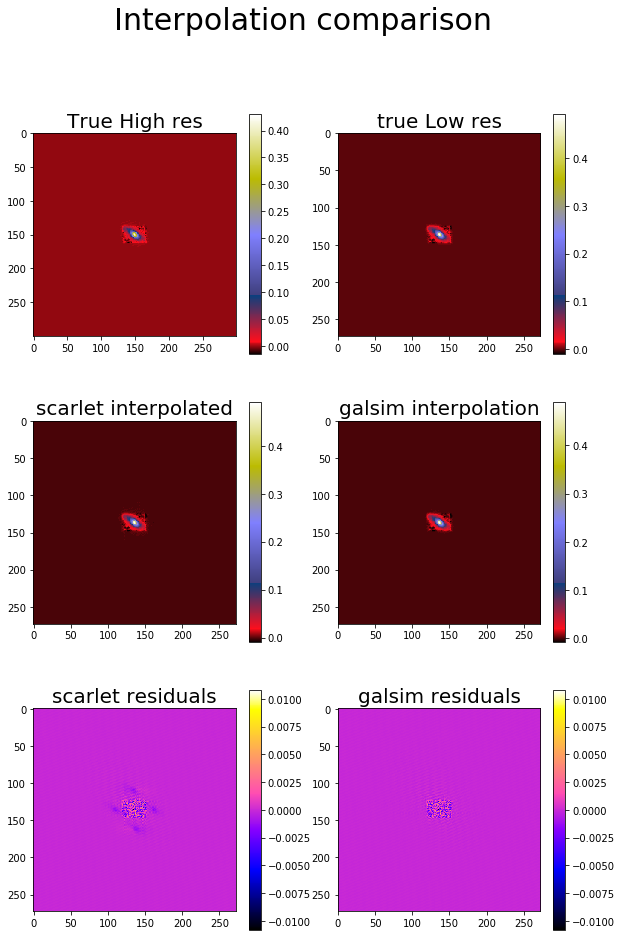

difference with scarlet fit -0.00911750703676506
difference with galsim fit -0.0016589067271328695
difference in psf 0.0009766237120527599
difference in data 0.0014111672375738404
Scarlet timing
CPU times: user 2.58 s, sys: 995 ms, total: 3.58 s
Wall time: 2.42 s
Galsim timing
CPU times: user 539 ms, sys: 124 ms, total: 663 ms
Wall time: 183 ms
scarlet SDR:  17.550336087055207
galsim SDR:  17.57461073442445


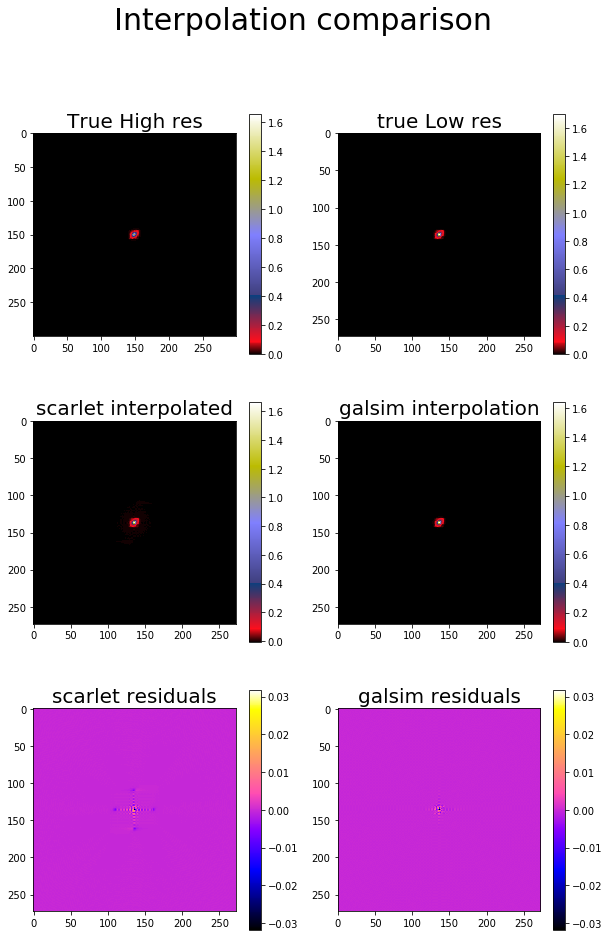

difference with scarlet fit -0.006387331350983905
difference with galsim fit 0.0010491265347497558
difference in psf 0.0009766237120527599
difference in data -0.0012978764625033445
Scarlet timing
CPU times: user 2.17 s, sys: 819 ms, total: 2.99 s
Wall time: 2.02 s
Galsim timing
CPU times: user 567 ms, sys: 111 ms, total: 678 ms
Wall time: 158 ms
scarlet SDR:  17.068865507374817
galsim SDR:  17.23156752043184


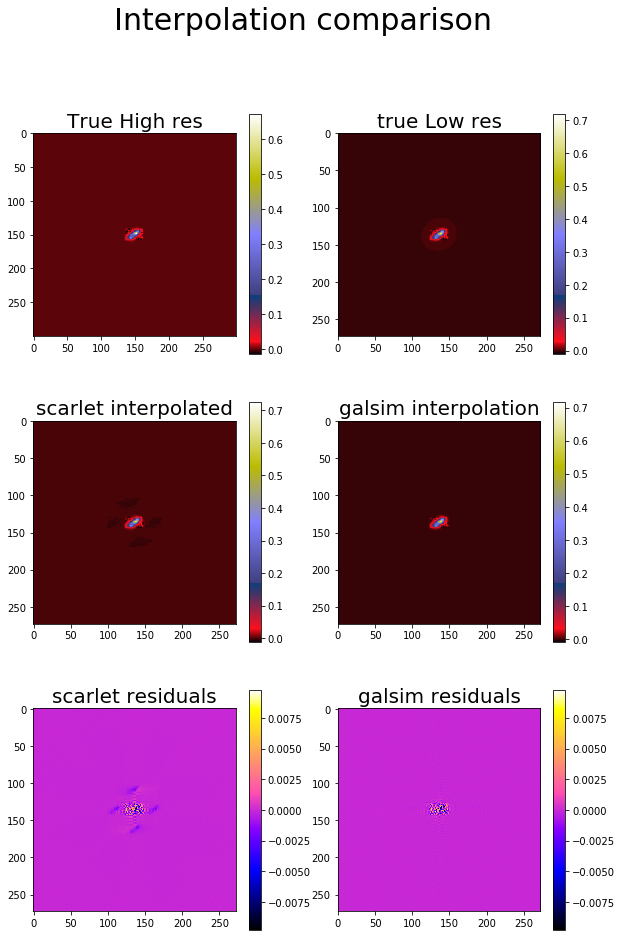

difference with scarlet fit -0.008128320419281243
difference with galsim fit -0.0006721496659163329
difference in psf 0.0009766237120527599
difference in data 0.00043120744375668707
Scarlet timing
CPU times: user 2.1 s, sys: 871 ms, total: 2.97 s
Wall time: 1.99 s
Galsim timing
CPU times: user 261 ms, sys: 293 ms, total: 554 ms
Wall time: 193 ms
scarlet SDR:  17.19541974626118
galsim SDR:  16.740543885903033


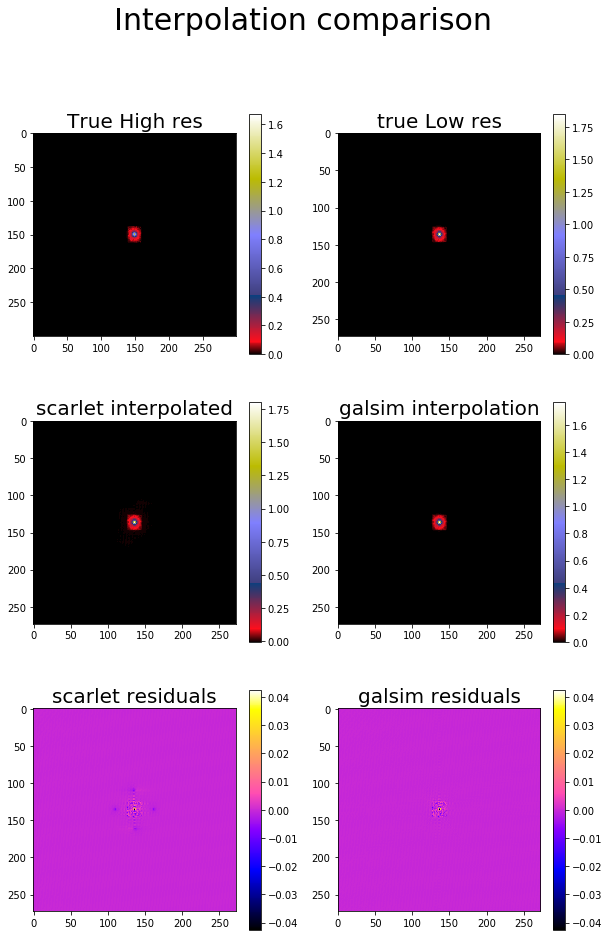

difference with scarlet fit -0.007141122056470328
difference with galsim fit 0.0003022010521843699
difference in psf 0.0009766237120527599
difference in data -0.0005487568524447095
Scarlet timing
CPU times: user 2.41 s, sys: 904 ms, total: 3.32 s
Wall time: 2.21 s
Galsim timing
CPU times: user 204 ms, sys: 276 ms, total: 480 ms
Wall time: 221 ms
scarlet SDR:  12.790991677298297
galsim SDR:  13.11098240215384


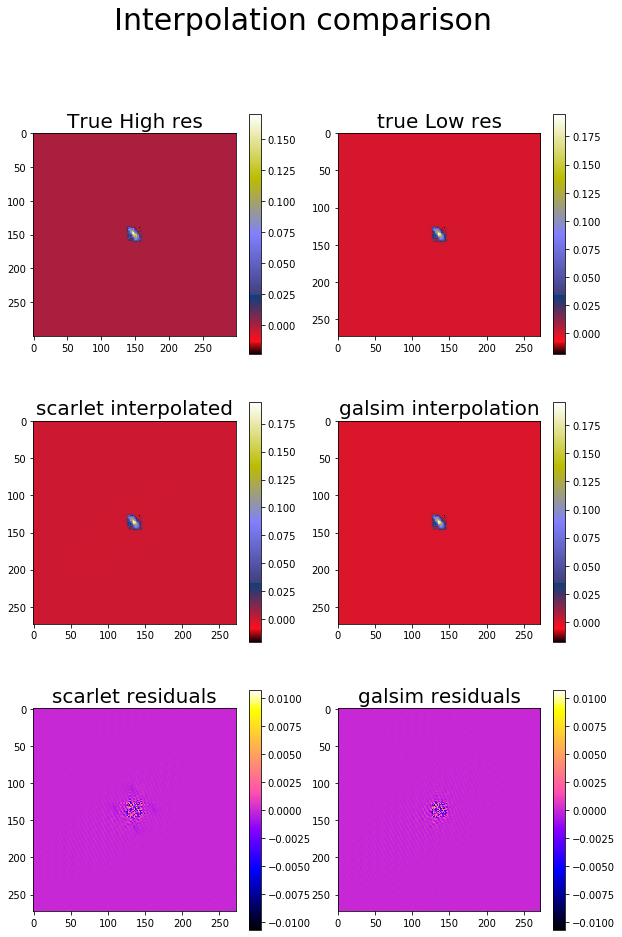

difference with scarlet fit -0.012137493200940375
difference with galsim fit -0.004660155072994332
difference in psf 0.0009766237120527599
difference in data 0.0043903852675480914
Scarlet timing
CPU times: user 2.47 s, sys: 963 ms, total: 3.43 s
Wall time: 2.32 s
Galsim timing
CPU times: user 476 ms, sys: 138 ms, total: 614 ms
Wall time: 197 ms
scarlet SDR:  14.448066191967344
galsim SDR:  13.20333591319953


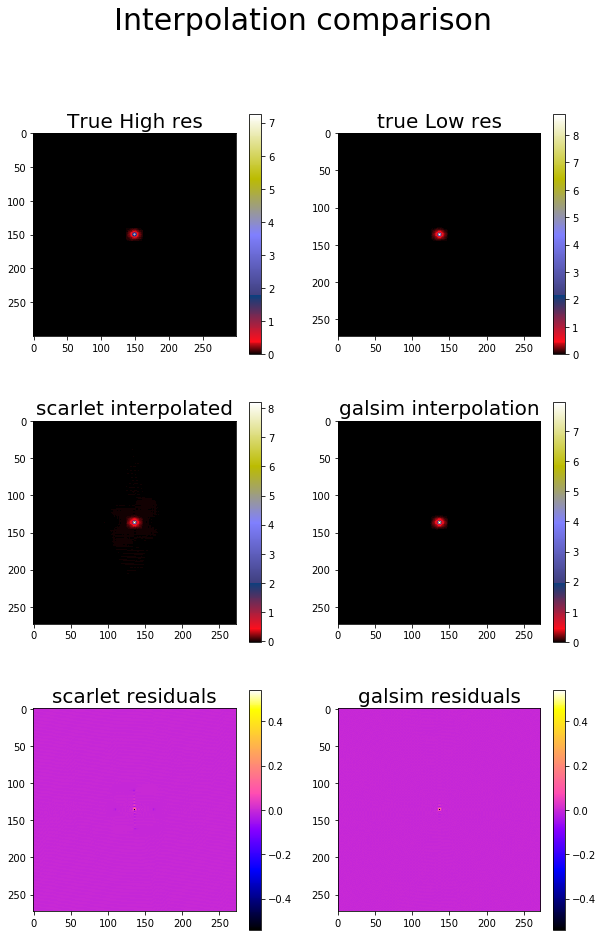

difference with scarlet fit -0.008806200059996883
difference with galsim fit -0.0013597463215231365
difference in psf 0.0009766237120527599
difference in data 0.0011033962050999158
Scarlet timing
CPU times: user 2.76 s, sys: 1.05 s, total: 3.81 s
Wall time: 2.59 s
Galsim timing
CPU times: user 226 ms, sys: 273 ms, total: 499 ms
Wall time: 251 ms
scarlet SDR:  17.07679254133
galsim SDR:  17.29922574868577


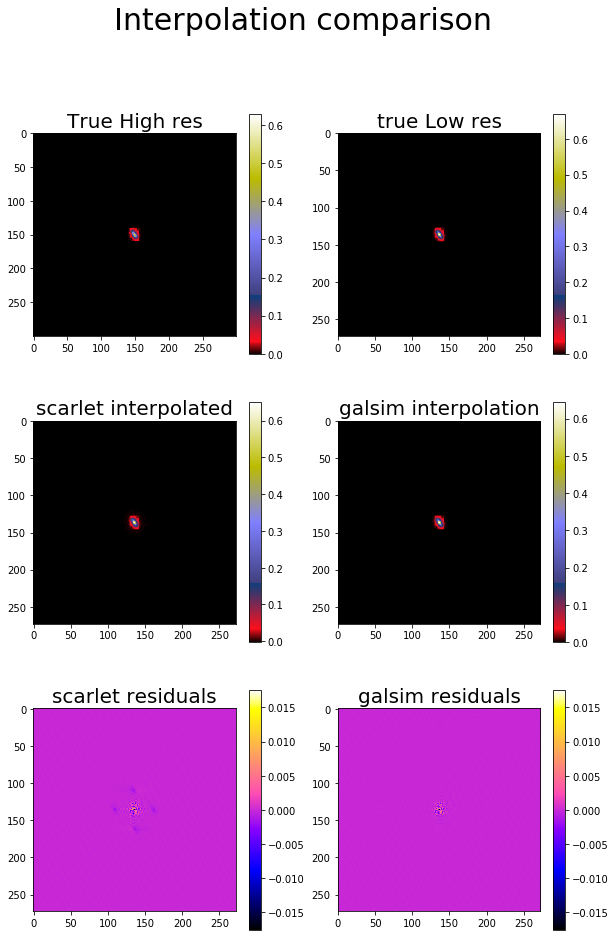

difference with scarlet fit -0.008069711983407446
difference with galsim fit -0.0006258565218353329
difference in psf 0.0009766237120527599
difference in data 0.00037333660596272633
Scarlet timing
CPU times: user 2.51 s, sys: 1.03 s, total: 3.55 s
Wall time: 2.39 s
Galsim timing
CPU times: user 219 ms, sys: 308 ms, total: 528 ms
Wall time: 201 ms
scarlet SDR:  18.885956548572675
galsim SDR:  19.42173288722841


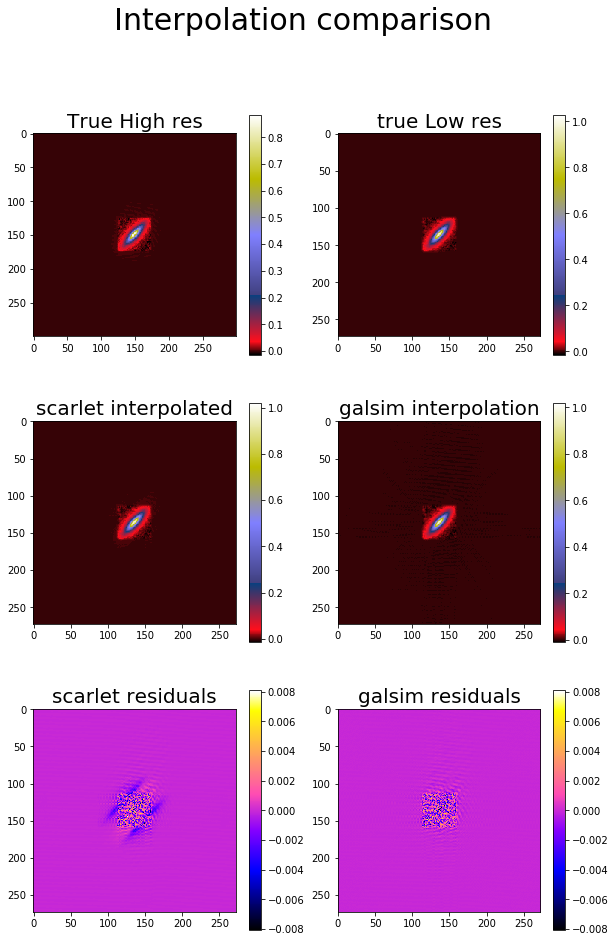

difference with scarlet fit -0.0077463935354391555
difference with galsim fit -0.00029624470621447685
difference in psf 0.0009766237120527599
difference in data 5.2173535918464964e-05
Scarlet timing
CPU times: user 2.14 s, sys: 883 ms, total: 3.02 s
Wall time: 2.04 s
Galsim timing
CPU times: user 536 ms, sys: 139 ms, total: 674 ms
Wall time: 197 ms
scarlet SDR:  17.98187435163505
galsim SDR:  18.989616961835484


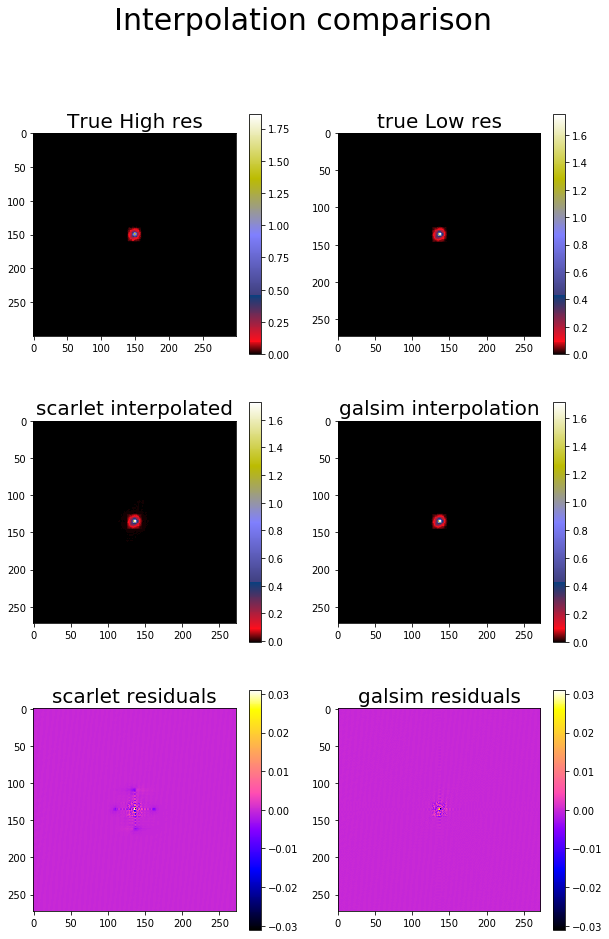

difference with scarlet fit -0.007113118178574185
difference with galsim fit 0.0003324599156985242
difference in psf 0.0009766237120527599
difference in data -0.000576351803389441
Scarlet timing
CPU times: user 2.27 s, sys: 948 ms, total: 3.21 s
Wall time: 2.31 s
Galsim timing
CPU times: user 468 ms, sys: 183 ms, total: 651 ms
Wall time: 242 ms
scarlet SDR:  18.578938985154544
galsim SDR:  19.34106681805889


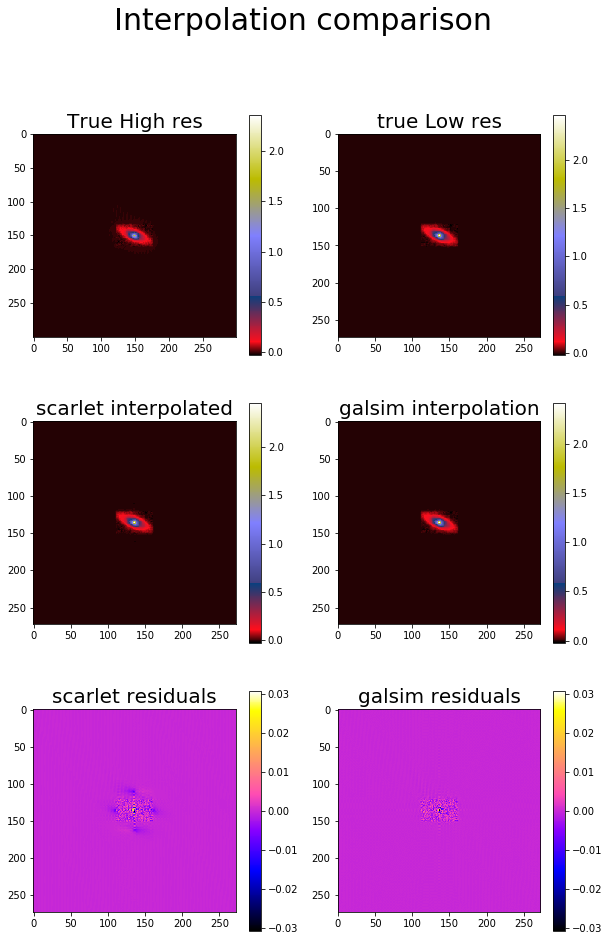

difference with scarlet fit -0.008110133713071122
difference with galsim fit -0.0006582811668958133
difference in psf 0.0009766237120527599
difference in data 0.00041489530756078086


In [5]:
survey_hr = EUCLID
survey_lr = WFIRST

n_hr = 300
n_lr = np.around(n_hr*survey_hr['pixel']/survey_lr['pixel'])
c = 0

def SDR(X_true, X):
    return 10*np.log10(np.sum(X_true**2)**0.5/np.sum((X_true-X)**2)**0.5)

for i in range(39,50):    
    #make the simulations
    data_hr, data_lr, psf_hr, psf_lr, angle = mk_sim(i, survey_hr, survey_lr, (n_hr, n_hr), (n_lr, n_lr))
    shape = (len(channels), n_hr,n_hr)
    obs_lr, obs_hr = interp_scarlet(data_hr, data_lr, psf_hr, psf_lr)

    #GSO from psf_hr for galsim
    psf_hr_galsim = galsim.InterpolatedImage(galsim.Image(psf_hr[0]), 
                                               scale = survey_hr['pixel'])
    #deconvolution kernel for diff kernel
    deconv = galsim.Deconvolve(psf_hr_galsim)
    #Interpolation of low resolution psf at high resolution
    psf_lr_hr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                               scale = survey_lr['pixel'])
    #Difference kernel from galsim
    diff_gal = galsim.Convolve(deconv, psf_lr_hr)
    #Run scarlet on simulations:
    print('Scarlet timing')
    %time obs_lr.render(data_hr.array[None,:,:])
    interp_scar = obs_lr.render(data_hr.array[None,:,:])

    #Difference kernel from scarlet
    diff_scar = obs_lr.diff_psf
    
    #Run galsim on simlations
    print('Galsim timing')
    %time  interp_galsim(data_hr, data_lr, diff_gal, angle, survey_hr['pixel'], survey_lr['pixel'])
    interp_gal = interp_galsim(data_hr, data_lr, diff_gal, angle, survey_hr['pixel'], survey_lr['pixel'])
    
    #Reconstruction of the low resolution psf by galsim from hr psf and diff kernel (sanity check)
    rec_gal = galsim.Convolve(diff_gal, psf_hr_galsim).drawImage(nx=npsf,ny=npsf, scale=survey_hr['pixel'])
    
    #True psf
    gal_lr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                      scale=survey_lr['pixel']).drawImage(nx=npsf,ny=npsf,scale=survey_hr['pixel']
                                                                         , method = 'real_space')
    #Reconstruction of the low resolution psf by SCARLET from hr psf and diff kernl (sanity check)
    rec_scar = scarlet.fft.convolve(scarlet.fft.Fourier(psf_hr[0]), scarlet.fft.Fourier(diff_scar.image[0]))
    
    if c == 0:
        r_scar=(gal_lr.array-rec_scar.image)
        figure(figsize = (15,5))
        plt.suptitle('comparison scarlet', fontsize = 20)
        subplot(131)
        title('scarlet PSF')
        imshow((rec_scar.image))
        plt.colorbar()
        subplot(132)
        title('true PSF')
        imshow((gal_lr.array))
        plt.colorbar()
        subplot(133)
        title('Residuals')
        imshow((r_scar)[10:-10,10:-10], cmap = mymap, 
               vmin = -np.max(np.abs(r_scar)), vmax = np.max(np.abs(r_scar)))
        plt.colorbar()

        r_gal = (gal_lr.array-rec_gal.array)
        figure(figsize = (15,5))
        plt.suptitle('comparison galsim', fontsize = 20)
        subplot(131)
        title('galsim PSF')
        imshow((rec_gal.array))
        plt.colorbar()
        subplot(132)
        title('true PSF')
        imshow((gal_lr.array))
        plt.colorbar()
        subplot(133)
        title('Residuals')
        imshow((r_gal), cmap = mymap, 
               vmin = -np.max(np.max(r_gal)), vmax = np.max(np.max(r_gal)))
        plt.colorbar()
    
    print('scarlet SDR: ', SDR(data_lr.array, interp_scar[0]))
    print('galsim SDR: ', SDR(data_lr.array, interp_gal.array))
    c+=1
    gal_res = data_lr.array-interp_gal.array
    scar_res = data_lr.array-interp_scar[0]
    figure(figsize = (10,15))
    plt.suptitle('Interpolation comparison', fontsize=30)
    subplot(321)
    title('True High res', fontsize = 20)
    imshow(data_hr.array)
    plt.colorbar()
    subplot(322)
    title('true Low res', fontsize = 20)
    imshow(data_lr.array)
    plt.colorbar()
    subplot(323)
    title('scarlet interpolated', fontsize = 20)
    imshow((interp_scar[0]))
    plt.colorbar()
    subplot(324)
    title('galsim interpolation', fontsize = 20)
    imshow((interp_gal.array))
    plt.colorbar()
    subplot(325)
    title('scarlet residuals', fontsize = 20)
    imshow(-(scar_res), cmap=mymap, vmin = -np.max(np.abs(scar_res)), vmax = np.max(np.abs(scar_res)))
    plt.colorbar()
    subplot(326)
    title('galsim residuals', fontsize = 20)
    imshow(-(gal_res), cmap=mymap, vmin = -np.max(np.abs(scar_res)), vmax = np.max(np.abs(scar_res)))
    plt.colorbar()
    show()
    
    print('difference with scarlet fit',1-np.sum(data_lr.array)/np.sum(interp_scar[0]))
    print('difference with galsim fit',1-np.sum(data_lr.array)/np.sum(interp_gal.array))
    print('difference in psf', 1-np.sum(gal_lr.array)/np.sum(rec_scar.image))
    print('difference in data', 1-np.sum(data_hr.array)/np.sum(data_lr.array))